# Final-Project-Jingjing-Li_Smitali-Patnaik

## Introduction

## Supervised Learning Idea and Data Split

In [2]:
# Prepare the environment for Windows operation systems
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Import the modules
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
from math import *
# Create a new Spark session
spark = SparkSession.builder.getOrCreate()

# Configurate the Spark session
ps.set_option("compute.default_index_type", "distributed")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", True)

In [4]:
# Read in data 
spdf=spark.read.load("C:/Users/smipa/Downloads/ParisHousing.csv",
                     format="csv",sep=",", inferSchema="true", header="true")
spdf.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|    price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|       75523|            3|      0|      1|    63|    9373|            3|            8|2005|         0|                1|    4313| 9005|   956|             0|           7|7559081.5|
|       80771|           39|      1|      1|    98|   39381|            8|            6|2015|         1|                0|    3653| 2436|   128|             1|           2|8085989.5|
|       55712|           58|      0|      1|    19|   34457|            6|           

#### Splitting the priec ecolumn into categories. We have used 3 categories here for the price. 
#### '0' represents "Low Price"
#### '1' represents "Medium Price"
#### '2' represents "High Price"



In [6]:
from pyspark.sql.functions import when
quantiles = spdf.approxQuantile("price", [0.25, 0.5, 0.75], 0)
spdf = spdf.withColumn("cat_price", when(spdf.price <= quantiles[0] ,0) \
      .when((spdf.price > quantiles[0]) & (spdf.price <= quantiles[1] ),1) \
      .otherwise(2))
spdf.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|    price|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+---------+
|       75523|            3|      0|      1|    63|    9373|            3|            8|2005|         0|                1|    4313| 9005|   956|             0|           7|7559081.5|        2|
|       80771|           39|      1|      1|    98|   39381|            8|            6|2015|         1|                0|    3653| 2436|   128|             1|           2|8085989.5|        2|
|       55712|           58|      0

Then, we split data into two parts for train and test respectively.

In [8]:
# Split data
train, test = spdf.randomSplit(weights=[0.8,0.2], seed=200)

In [9]:
train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+---------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|10313.5|        0|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|14431.3|        0|
|         123|           61|      0|      0| 

In [5]:
# Display initial 5 records
train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|  price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+-------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|10313.5|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|14431.3|
|         123|           61|      0|      0|     1|   33633|            9|            1|2011|  

For modeling purpose, we need to remove supervising variable to get predictors. 

In [13]:
# Determine predictor for modeling later
X_train=train.drop('price')
X_train.show(5)

+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|squareMeters|numberOfRooms|hasYard|hasPool|floors|cityCode|cityPartRange|numPrevOwners|made|isNewBuilt|hasStormProtector|basement|attic|garage|hasStorageRoom|hasGuestRoom|cat_price|
+------------+-------------+-------+-------+------+--------+-------------+-------------+----+----------+-----------------+--------+-----+------+--------------+------------+---------+
|          89|           33|      0|      0|    72|   61648|            3|            4|1995|         0|                1|    3114| 1258|   264|             1|           9|        0|
|         111|           32|      0|      1|    34|   80623|            1|            4|2003|         1|                0|    2239| 2795|   951|             1|           7|        0|
|         123|           61|      0|      0|     1|   33633|            9|           

We also need define the supervising variable.

In [14]:
# Determine the reponse variable
y_train=train.select('price')
y_train.show(5)

+-------+
|  price|
+-------+
|10313.5|
|14431.3|
|13229.1|
|15488.0|
|22670.7|
+-------+
only showing top 5 rows



#### This is just for show purpose. As the corr is same, need to delete it in the final version

In [21]:
#### Min Max Scaling of Xtrain
Xcols=list(X_train.columns)

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import SQLTransformer,VectorAssembler,MinMaxScaler
from pyspark.ml import Pipeline
assembler = VectorAssembler(inputCols=Xcols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")
pipeline = Pipeline(stages=[assembler, scaler])
scalerModel = pipeline.fit(X_train)
scaled_train = scalerModel.transform(X_train)
scaled_train=scaled_train.select('features_scaled')
scaled_train.show()

# Getting all the transfomred featy
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType

def split_array_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return F.udf(to_list, ArrayType(DoubleType()))(col)

df3 = scaled_train.select(split_array_to_list(F.col("features_scaled")).alias("split_int"))\
    .select([F.col("split_int")[i] for i in range(len(Xcols))])
df3.show()

+--------------------+
|     features_scaled|
+--------------------+
|[0.0,0.3232323232...|
|[2.20198178360524...|
|(17,[0,1,5,6,8,10...|
|[3.90351316184566...|
|[5.20468421579421...|
|[5.40486437794014...|
|[5.90531478330497...|
|[6.00540486437794...|
|[6.30567510759683...|
|[6.40576518866980...|
|[7.40666599939946...|
|[7.40666599939946...|
|[8.70783705334801...|
|[9.10819737763987...|
|[9.80882794515063...|
|[0.00107096386748...|
|[0.00113101791612...|
|[0.00121108998098...|
|[0.00122109898909...|
|[0.00146131518366...|
+--------------------+
only showing top 20 rows

+--------------------+-------------------+------------+------------+-------------------+-------------------+------------------+------------------+-------------------+------------+-------------+--------------------+-------------------+--------------------+-------------+-------------------+-------------+
|        split_int[0]|       split_int[1]|split_int[2]|split_int[3]|       split_int[4]|       split_int[5]|      spli

In [23]:

train_col=X_train.columns
df3=df3.toDF(*train_col)
df3.show()


+--------------------+-------------------+-------+-------+-------------------+-------------------+------------------+------------------+-------------------+----------+-----------------+--------------------+-------------------+--------------------+--------------+-------------------+---------+
|        squareMeters|      numberOfRooms|hasYard|hasPool|             floors|           cityCode|     cityPartRange|     numPrevOwners|               made|isNewBuilt|hasStormProtector|            basement|              attic|              garage|hasStorageRoom|       hasGuestRoom|cat_price|
+--------------------+-------------------+-------+-------+-------------------+-------------------+------------------+------------------+-------------------+----------+-----------------+--------------------+-------------------+--------------------+--------------+-------------------+---------+
|                 0.0|0.32323232323232326|    0.0|    0.0| 0.7171717171717172| 0.6167583791895949|0.2222222222222222|0.33

In [24]:
##correleation b/w scaled data

train_1=df3.to_pandas_on_spark()
y_train_ps=y_train.to_pandas_on_spark()
ps_train_scaled=train_1.join(y_train_ps)
ps_train_scaled.corr()

C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,cat_price,price
squareMeters,1.000000,0.018112,-0.006920,-0.007275,0.001266,0.003348,0.009571,0.021107,-0.011790,-0.017515,0.013962,-0.003347,0.000494,-0.021376,0.000758,-0.005259,0.913687,0.999999
numberOfRooms,0.018112,1.000000,-0.002026,0.025064,0.025580,0.008786,0.003964,0.022695,0.006171,0.002984,-0.019973,-0.012659,0.017830,0.020140,-0.007714,-0.028996,0.025584,0.018139
hasYard,-0.006920,-0.002026,1.000000,0.022319,0.007221,0.011608,0.000510,0.013940,-0.001031,-0.019186,-0.014477,-0.012269,-0.008550,-0.009474,-0.016018,-0.009306,-0.007448,-0.006379
hasPool,-0.007275,0.025064,0.022319,1.000000,-0.004498,0.002839,0.010935,-0.011100,0.004553,-0.000551,0.008231,-0.004457,-0.010662,0.003959,0.002272,0.010486,0.003308,-0.006744
floors,0.001266,0.025580,0.007221,-0.004498,1.000000,0.003560,0.003539,0.002120,0.008657,0.011376,-0.009689,0.013451,0.007498,0.013224,0.004201,-0.015645,-0.001498,0.001813
cityCode,0.003348,0.008786,0.011608,0.002839,0.003560,1.000000,0.006340,-0.010801,0.022962,0.002324,0.002648,0.000262,-0.001843,-0.000273,0.002974,-0.000929,-0.007608,0.003354
cityPartRange,0.009571,0.003964,0.000510,0.010935,0.003539,0.006340,1.000000,0.007545,0.001559,-0.000573,0.011112,0.005079,0.010184,0.006154,-0.011989,-0.007684,0.008556,0.009624
numPrevOwners,0.021107,0.022695,0.013940,-0.011100,0.002120,-0.010801,0.007545,1.000000,0.002941,-0.019256,0.003950,0.006442,0.002745,0.023401,0.031660,-0.004088,0.022560,0.021112
made,-0.011790,0.006171,-0.001031,0.004553,0.008657,0.022962,0.001559,0.002941,1.000000,-0.005893,-0.005240,-0.008512,0.007095,0.014569,-0.008558,-0.010441,-0.009393,-0.011787
isNewBuilt,-0.017515,0.002984,-0.019186,-0.000551,0.011376,0.002324,-0.000573,-0.019256,-0.005893,1.000000,-0.000760,-0.012884,0.023872,-0.001470,0.002765,0.026291,-0.016416,-0.017491


## EDA

#### First, we are interested in seeing if there is relationshipes between the Predictors and the predicted avairable. This starts with quantifying the correlation between the variables.Here the spark dataframe is converter to pandas on spark dataframe and the data is studies using plots and tables. 

In [123]:
train_ps=train.to_pandas_on_spark()

C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\dataframe.py:3313: FutureWarning:

DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.



#### Correlation table states that only squareMeters has the strongest linear relationship with price variable. Other variables do not show any significant relationship. As we see there are also many discrete variablles in the data. The relationship may not be strong with a simple correlation step.

In [124]:
train_ps.corr()

C:\Users\smipa\anaconda3\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
squareMeters,1.000000,0.018112,-0.006920,-0.007275,0.001266,0.003348,0.009571,0.021107,-0.011790,-0.017515,0.013962,-0.003347,0.000494,-0.021376,0.000758,-0.005259,0.999999,0.913687
numberOfRooms,0.018112,1.000000,-0.002026,0.025064,0.025580,0.008786,0.003964,0.022695,0.006171,0.002984,-0.019973,-0.012659,0.017830,0.020140,-0.007714,-0.028996,0.018139,0.025584
hasYard,-0.006920,-0.002026,1.000000,0.022319,0.007221,0.011608,0.000510,0.013940,-0.001031,-0.019186,-0.014477,-0.012269,-0.008550,-0.009474,-0.016018,-0.009306,-0.006379,-0.007448
hasPool,-0.007275,0.025064,0.022319,1.000000,-0.004498,0.002839,0.010935,-0.011100,0.004553,-0.000551,0.008231,-0.004457,-0.010662,0.003959,0.002272,0.010486,-0.006744,0.003308
floors,0.001266,0.025580,0.007221,-0.004498,1.000000,0.003560,0.003539,0.002120,0.008657,0.011376,-0.009689,0.013451,0.007498,0.013224,0.004201,-0.015645,0.001813,-0.001498
cityCode,0.003348,0.008786,0.011608,0.002839,0.003560,1.000000,0.006340,-0.010801,0.022962,0.002324,0.002648,0.000262,-0.001843,-0.000273,0.002974,-0.000929,0.003354,-0.007608
cityPartRange,0.009571,0.003964,0.000510,0.010935,0.003539,0.006340,1.000000,0.007545,0.001559,-0.000573,0.011112,0.005079,0.010184,0.006154,-0.011989,-0.007684,0.009624,0.008556
numPrevOwners,0.021107,0.022695,0.013940,-0.011100,0.002120,-0.010801,0.007545,1.000000,0.002941,-0.019256,0.003950,0.006442,0.002745,0.023401,0.031660,-0.004088,0.021112,0.022560
made,-0.011790,0.006171,-0.001031,0.004553,0.008657,0.022962,0.001559,0.002941,1.000000,-0.005893,-0.005240,-0.008512,0.007095,0.014569,-0.008558,-0.010441,-0.011787,-0.009393
isNewBuilt,-0.017515,0.002984,-0.019186,-0.000551,0.011376,0.002324,-0.000573,-0.019256,-0.005893,1.000000,-0.000760,-0.012884,0.023872,-0.001470,0.002765,0.026291,-0.017491,-0.016416


In [125]:
#### We are here now taking the categorical datasets and checking relationship between them with a simple contingency table.
from pyspark.mllib.stat import Statistics
from pyspark.sql import DataFrame
train_ps.head(5)



,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
0,89,33,0,0,72,61648,3,4,1995,0,1,3114,1258,264,1,9,10313.5,0
1,111,32,0,1,34,80623,1,4,2003,1,0,2239,2795,951,1,7,14431.3,0
2,123,61,0,0,1,33633,9,1,2011,0,1,9390,6219,922,0,9,13229.1,0
3,128,38,0,1,6,8862,6,2,1990,0,0,6861,5769,442,0,5,15488.0,0
4,141,16,0,1,58,42248,5,4,1997,1,0,3411,8985,213,0,4,22670.7,0


In [126]:
train_ps.loc[train_ps['cat_price']==0,'price_cat_name']='Low_price'
train_ps.loc[train_ps['cat_price']==1,'price_cat_name']='Medium_price'
train_ps.loc[train_ps['cat_price']==2,'price_cat_name']='High_price'



In [143]:
dis_col=['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','made']
for i in dis_col:
    table = train_ps.pivot_table(values=i, index=[i],columns='price_cat_name', aggfunc='count',fill_value=0)
    print(table)


price_cat_name  High_price  Low_price  Medium_price
hasYard                                            
1                     2016       1033           990
0                     1987        973          1005
price_cat_name  High_price  Low_price  Medium_price
hasPool                                            
1                     1980        979          1009
0                     2023       1027           986
price_cat_name  High_price  Low_price  Medium_price
isNewBuilt                                         
1                     1953       1015          1010
0                     2050        991           985
price_cat_name     High_price  Low_price  Medium_price
hasStormProtector                                     
1                        2011        992           992
0                        1992       1014          1003
price_cat_name  High_price  Low_price  Medium_price
hasStorageRoom                                     
1                     1992       1009          1012


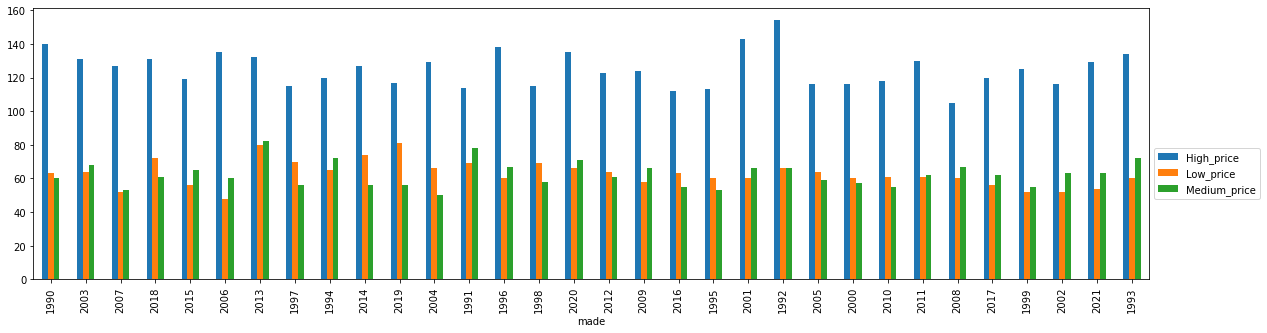

In [171]:
from matplotlib.pyplot import figure
table2 = train_ps.pivot_table(values='made', index=['made'],columns='price_cat_name', aggfunc='count',fill_value=0).plot.bar(stacked=False)
plt.gcf().set_size_inches(20, 5)
plt.legend( bbox_to_anchor=(1, 0.5))


In [28]:
train_ps.groupby(["hasYard"]).median() 

,squareMeters,numberOfRooms,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,cat_price
hasYard,,,,,,,,,,,,,,,,,
1,50015,51,1,50,51582,5,5,2005,0,0,4992,5026,550,0,5,5010457.9,1
0,50223,51,0,50,49748,5,5,2005,1,1,5120,5032,560,1,5,5028282.1,2


In [29]:
train_ps[['squareMeters','numberOfRooms','price']].describe() 

,squareMeters,numberOfRooms,price
count,8004.000000,8004.000000,8.004000e+03
mean,49933.997626,50.583208,4.999808e+06
std,28857.052125,28.812682,2.885693e+06
min,89.000000,1.000000,1.031350e+04
25%,25004.000000,25.000000,2.508814e+06
50%,50102.000000,51.000000,5.015730e+06
75%,74880.000000,75.000000,7.494846e+06
max,99999.000000,100.000000,1.000677e+07


<AxesSubplot:xlabel='numberOfRooms', ylabel='price'>

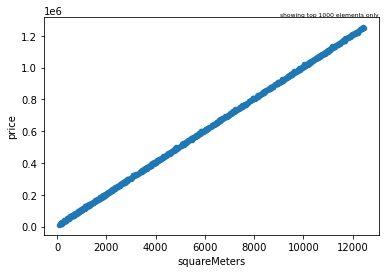

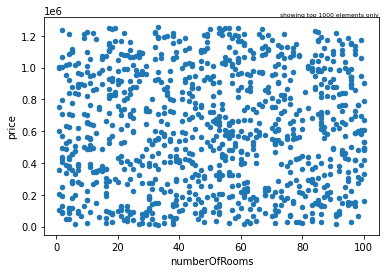

In [169]:
train_ps.plot(kind='scatter',x='squareMeters',y='price')
train_ps.plot(kind='scatter',x='numberOfRooms',y='price')

<AxesSubplot:ylabel='Frequency'>

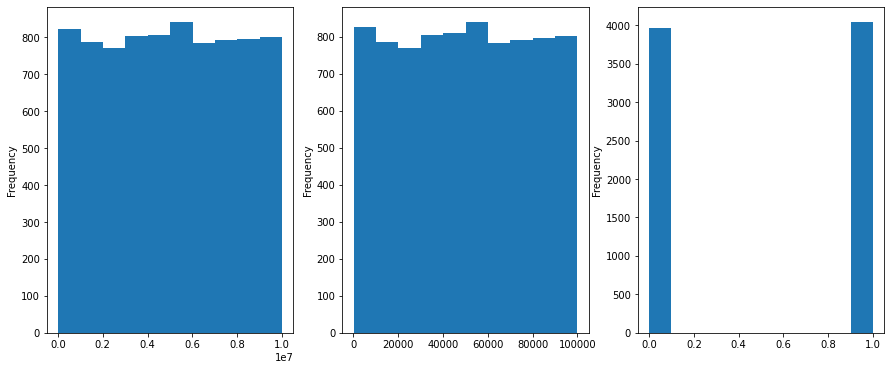

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6 ))
train_ps['price'].hist(ax=axes[0])
train_ps['squareMeters'].hist(ax=axes[1])
train_ps['hasYard'].hist(ax=axes[2])

<AxesSubplot:>

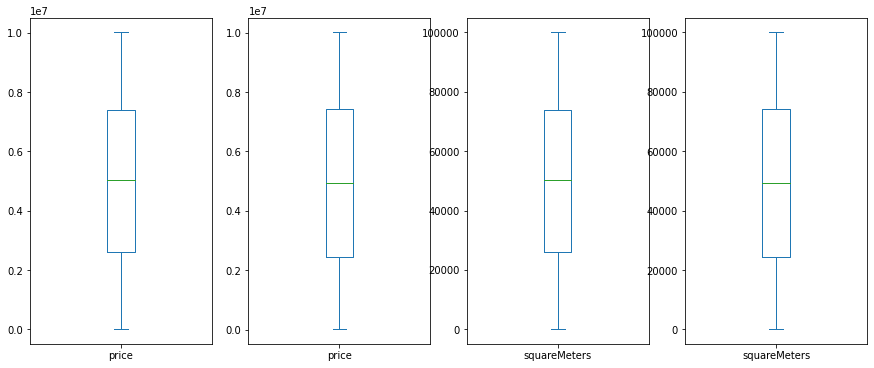

In [65]:
#train_ps['price'].plot.box(by=train_ps['hasYard'])
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(15, 6 ))
train_ps.loc[train_ps['hasYard']==0,'price'].plot.box(ax=axes[0])
train_ps.loc[train_ps['hasYard']==1,'price'].plot.box(ax=axes[1])
train_ps.loc[train_ps['hasYard']==0,'squareMeters'].plot.box(ax=axes[2])
train_ps.loc[train_ps['hasYard']==1,'squareMeters'].plot.box(ax=axes[3])


## Modeling

In [92]:
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [78]:
sqlTrans=SQLTransformer(
    statement="SELECT  squareMeters, hasYard, numberOfRooms, price as label FROM __THIS__"
)

In [79]:
assembler=VectorAssembler(inputCols=["squareMeters","hasYard","numberOfRooms"],outputCol="features",handleInvalid='keep')

In [80]:
lr= LinearRegression()

In [81]:
pipeline = Pipeline(stages= [sqlTrans, assembler, lr])

In [82]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0])\
    .addGrid(lr.fitIntercept, [False,True])\
    .addGrid(lr.elasticNetParam, [0])\
    .build()

In [83]:
assembler.transform(
    sqlTrans.transform(train)
).select("label","features").show(5)

+-------+----------------+
|  label|        features|
+-------+----------------+
|10313.5| [89.0,0.0,33.0]|
|14431.3|[111.0,0.0,32.0]|
|13229.1|[123.0,0.0,61.0]|
|15488.0|[128.0,0.0,38.0]|
|22670.7|[141.0,0.0,16.0]|
+-------+----------------+
only showing top 5 rows



In [84]:
lrmodel=lr.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("features", "label")
)

In [86]:
trainingSummary=lrmodel.summary

In [87]:
print("Coefficients: " + str(lrmodel.coefficients))

Coefficients: [99.99985048013832,3121.1887825121776,2.8374788191304043]


In [88]:
print("Intercept: " + str(lrmodel.intercept))

Intercept: 4696.798150003741


In [89]:
trainingSummary=lrmodel.summary
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

+-------------------+
|          residuals|
+-------------------+
|-3376.9216437673567|
|-1456.2808755112674|
| -3940.765967027708|
| -2116.603206588403|
| 3828.5232711906683|
+-------------------+
only showing top 5 rows

RMSE: 2879.232175
r2: 0.999999


In [90]:
preds=lrmodel.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label", "features")
)
     

In [91]:
preds.show(5)

+-------+----------------+------------------+
|  label|        features|        prediction|
+-------+----------------+------------------+
|10313.5| [89.0,0.0,33.0]|13690.421643767357|
|14431.3|[111.0,0.0,32.0]|15887.580875511267|
|13229.1|[123.0,0.0,61.0]| 17169.86596702771|
|15488.0|[128.0,0.0,38.0]|17604.603206588403|
|22670.7|[141.0,0.0,16.0]|18842.176728809332|
+-------+----------------+------------------+
only showing top 5 rows



In [93]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0])\
    .addGrid(lr.fitIntercept, [False,True])\
    .addGrid(lr.elasticNetParam, [0])\
    .build()

In [94]:
lr=LinearRegression()
crossval=CrossValidator(estimator = lr,
                         estimatorParamMaps=paramGrid,
                         evaluator=RegressionEvaluator(metricName='rmse'),
                         numFolds=5)      

In [95]:
cvModel=crossval.fit(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label","features")
)

In [96]:
list(zip(cvModel.avgMetrics,paramGrid))

[(2880.2080090479285,
  {Param(parent='LinearRegression_7cdcaff0f751', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_7cdcaff0f751', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LinearRegression_7cdcaff0f751', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (2880.2080090479285,
  {Param(parent='LinearRegression_7cdcaff0f751', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_7cdcaff0f751', name='fitIntercept', doc='whether to fit an intercept term.'): True,
   Param(parent='LinearRegression_7cdcaff0f751', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0})]

In [97]:
print(cvModel.bestModel._java_obj.intercept(), cvModel.bestModel._java_obj.coefficients())

4696.798150003741 [99.99985048013832,3121.1887825121776,2.8374788191304043]


In [98]:
preds=cvModel.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label","features")
)

In [99]:
preds.show(5)

+-------+----------------+------------------+
|  label|        features|        prediction|
+-------+----------------+------------------+
|10313.5| [89.0,0.0,33.0]|13690.421643767357|
|14431.3|[111.0,0.0,32.0]|15887.580875511267|
|13229.1|[123.0,0.0,61.0]| 17169.86596702771|
|15488.0|[128.0,0.0,38.0]|17604.603206588403|
|22670.7|[141.0,0.0,16.0]|18842.176728809332|
+-------+----------------+------------------+
only showing top 5 rows



In [101]:
RegressionEvaluator().evaluate(cvModel.transform(
    assembler.transform(
        sqlTrans.transform(train)
    ).select("label","features")
))

2879.2321752353055

### Random forest regression

### This model will have a pipeline to optimize the regsressors and use the best regressors.

In [1]:

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

In [ ]:
sqlTrans=SQLTransformer(statement="SELECT squareMeters, numberOfRooms, hasYard, hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price FROM __THIS__")
sqlTrans.transform(train).show(5)
assembler=VectorAssembler(inputCols=col,outputCol="features",handleInvalid='keep')
assembler.transform(sqlTrans.transform(train)).select("price","features").show(5)